# First attempt on a classifier discriminating ttbar and ttW

We can't train on just SS because the rate is too low.

In [1]:
import uproot
import awkward
import numpy as np
import pandas as pd
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (typ

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_hdf('../processor/data_X.h5')

In [4]:
sig_df = df[df['signal']==1]
bkg_df = df[df['signal']==0]

In [5]:
# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

In [6]:
nSmall

14837

In [7]:
# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.5*y_tmp.shape[0] ), random_state=42 )

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
variables = ['mll', 'njet', 'nbtag', 'st', 'ht', 'met', 'mjj_max', 'mlb_min', 'mlb_max', 'l0_pt', 'l1_pt']

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]
#X_myTest = X_tmp_test[['mll', 'MET_pt']]

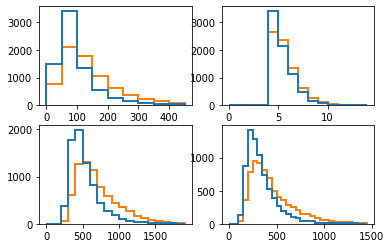

In [33]:
fig, axs = plt.subplots(2,2)

hist, bins, ax = axs[0,0].hist( [ X_train[['mll']][y_train==0].values, X_train[['mll']][y_train==1].values ], range(0,500,50), log=False, histtype='step', alpha=1, linewidth=2)
hist, bins, ax = axs[0,1].hist( [ X_train[['njet']][y_train==0].values, X_train[['njet']][y_train==1].values ], range(0,15,1), log=False, histtype='step', alpha=1, linewidth=2) 
hist, bins, ax = axs[1,0].hist( [ X_train[['st']][y_train==0].values, X_train[['st']][y_train==1].values ], range(0,2000,100), log=False, histtype='step', alpha=1, linewidth=2)
hist, bins, ax = axs[1,1].hist( [ X_train[['ht']][y_train==0].values, X_train[['ht']][y_train==1].values ], range(0,1500,50), log=False, histtype='step', alpha=1, linewidth=2) 

In [9]:
NHLayer = 5
epochs = 100
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

# add layers. we can play a bit with the hyper parameters here
model.add( tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train.shape[1], ))
model.add( tf.keras.layers.Dropout( rate = 0.01 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
model.add( tf.keras.layers.Dropout( rate = 0.01 ) )

#model.add( tf.keras.layers.Dense(units=128, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

#model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
model.add( tf.keras.layers.Dropout( rate = 0.01 ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

## Editor's note: don't go too crazy with nodes and layers if the data set is small or nothing will be learned at all.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total para

In [10]:
# verbose set to 0 (1 shows all the epochs)

history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1)
model.save( 'training.h5a' )

Train on 11869 samples, validate on 2968 samples
Epoch 1/100
11869/11869 [==============================]11869/11869 [==============================] - 1s 48us/step - loss: 3.9285 - acc: 0.5603 - val_loss: 1.4521 - val_acc: 0.5556

Epoch 2/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 1.5437 - acc: 0.5475 - val_loss: 0.9336 - val_acc: 0.5334

Epoch 3/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 1.1084 - acc: 0.5209 - val_loss: 0.7780 - val_acc: 0.5179

Epoch 4/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.8966 - acc: 0.5110 - val_loss: 0.7134 - val_acc: 0.5077

Epoch 5/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.7998 - acc: 0.5053 - val_loss: 0.7012 - val_acc: 0.5081

Epoch 6/100
11869/11869 [===============

11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6945 - acc: 0.5009 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 46/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6933 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 47/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.4933

Epoch 48/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6933 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 49/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6946 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 50/100
11869/11869 [==============================]11869/11869 [============================


Epoch 90/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 91/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 92/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 93/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 94/100
11869/11869 [==============================]11869/11869 [==============================] - 0s 4us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 95/100
11869/11869 [==============================]11869/11869 [==============

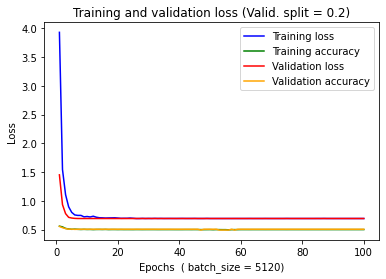

In [11]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [12]:
# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( model.predict( X_test.values  ) , index = X_test.index)

## as a comparison, use a mll based discriminator:
#y_test_pred_mll = (1-abs(X_myTest[['mll']]-91.2)/91.2).values.flatten()

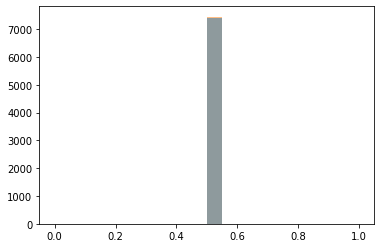

In [13]:
xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].values, y_test_pred[y_test==1].values ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

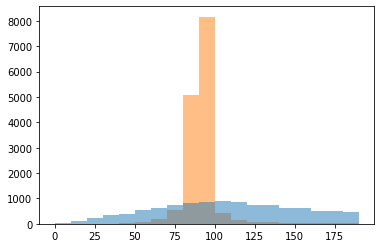

In [15]:
# just looking at M(ll)

xbin = range(0,200,10)
hist, bins, ax = plt.hist( [ X_myTest[['mll']][y_test==0].values, X_myTest[['mll']][y_test==1].values ], xbin, log=False, histtype='stepfilled', alpha=0.5) 

In [16]:
print(y_test_pred[y_test==0].values)
print(y_test_pred[y_test==1].values)
print(y_test_pred[y_test==0].size)
print(y_test_pred[y_test==1].size)

[[0.01122133]
 [0.00084156]
 [0.38485926]
 ...
 [0.21763235]
 [0.0083673 ]
 [0.00079956]]
[[0.48389024]
 [0.98845613]
 [0.953457  ]
 ...
 [0.58535916]
 [0.38479832]
 [0.55152327]]
15189
15010


In [ ]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN=' + str(round(auc_val_test,4) ))

fpr_test_alt, tpr_test_alt, thresholds_test_alt = roc_curve( y_test, y_test_pred_mll )
auc_val_test_alt = auc(fpr_test_alt, tpr_test_alt)

plt.plot( tpr_test_alt, 1-fpr_test_alt, 'b', label= 'AUC M(ll)=' + str(round(auc_val_test_alt,4) ), color='red')

plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


Some observations:
- with small data set, the performance deterioates pretty quickly when the network becomes too complicated
- without using the lepton charge, the NN underperforms wrt M(ll), but gets quite close once the hyper parameters are (roughly) optimized
- overtraining seems to be not a big problem, and one can use a large number of epochs
- we still use a small data set
- maybe a different model is better suited for our problem?



# Using some physics knowledge (4 vectors)

We can try to use a network that knows about 4 vectors.

This is WIP!


In [ ]:
from lbn import LBN, LBNLayer

In [ ]:
def convertTo4Vec( df ):

    eventSelection = ( (df['nLepton']==2) & (df['nVetoLepton']==2) )
        
    leptons = JaggedCandidateArray.candidatesfromcounts(
        df['nLepton'],
        pt=df['Lepton_pt'],
        eta=df['Lepton_eta'],
        phi=df['Lepton_phi'],
        mass= df['Lepton_mass'],
        charge=df['Lepton_pdgId']/abs(df['Lepton_pdgId'])
    )
    
    leptons = leptons[eventSelection]
    
    dileptons = leptons.choose(2)
    
    #dileptons.i0.p4.energy # gives the energy
    
    leading = np.array(list(zip(dileptons.i0.p4.energy.flatten(), dileptons.i0.p4.x.flatten(),dileptons.i0.p4.y.flatten(),dileptons.i0.p4.z.flatten())))
    subleading = np.array(list(zip(dileptons.i1.p4.energy.flatten(), dileptons.i1.p4.x.flatten(),dileptons.i1.p4.y.flatten(),dileptons.i1.p4.z.flatten())))

    leps = np.array(list(zip(leading,subleading)))
    
    return leps # not yet sure how to do this. have to zip?

In [ ]:
bkg = LazyDataFrame(bkg_tree, flatten=True)
sig = LazyDataFrame(sig_tree, flatten=True)


inputs_sig = convertTo4Vec( sig )
inputs_bkg = convertTo4Vec( bkg )

nSignal = len(inputs_sig)

# training
inputs_sig_train = inputs_sig[:int(nSignal/2)]
inputs_bkg_train = inputs_bkg[:int(nSignal/2)]

inputs = np.concatenate((inputs_sig_train,inputs_bkg_train))

# test
inputs_sig_test = inputs_sig[int(nSignal/2):nSignal]
inputs_bkg_test = inputs_bkg[int(nSignal/2):nSignal]

inputs_test = np.concatenate((inputs_sig_test,inputs_bkg_test))


# training
y_sig = np.ones(len(inputs_sig_train))
y_bkg = np.zeros(len(inputs_bkg_train))
y_tmp = np.concatenate((y_sig,y_bkg))

# test
y_sig_test = np.ones(len(inputs_sig_test))
y_bkg_test = np.zeros(len(inputs_bkg_test))
y_test = np.concatenate((y_sig_test,y_bkg_test))

print (np.shape(inputs))
print (np.shape(y_tmp))

In [ ]:
# start a sequential model
model = tf.keras.models.Sequential()

# add the LBN layer
lbn_layer = LBNLayer((2, 4), n_particles=2, boost_mode=LBN.PAIRS, features=["E", "px", "py", "pz"])

model.add(lbn_layer)

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

#model.compile(loss="categorical_crossentropy")

features = model.predict(inputs)

In [ ]:

history = model.fit(inputs, y_tmp, epochs=1000, batch_size=batch_size, validation_split=validation_split)

In [ ]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [ ]:
y_test_pred = pd.DataFrame( model.predict( inputs_test  ) )

In [ ]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )

In [ ]:
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'Auc=' + str(round(auc_val_test,4) ))

#plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
#                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')